### Install SECANT from GitHub
##### - Before running, make sure runtime has been set to GPU

In [1]:
!pip install git+https://github.com/tarot0410/SECANT.git -q

### Import packages

In [2]:
from SECANT import SECANT as SE
import torch
import numpy as np
import pandas as pd
import umap.umap_ as umap
import matplotlib.pyplot as plt
import itertools
from itertools import combinations
import time

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev) 

### Mount Google Drive for accessing external data

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

### Analyzing 10X10k_PBMC data

In [3]:
### Load in ADT confident cell type label
url = 'https://raw.githubusercontent.com/tarot0410/SECANT/main/real_data/10X10k_PBMC/'
ADT_df = pd.read_csv(url + 'label_10X10k.csv')
ADT_Lbl = SE.df_to_tensor(ADT_df)[:,0]   
ADT_Lbl = ADT_Lbl - 1 # make sure values in ADT_Lbl range from 0, and the maximum value refers to "uncertain" group
# Check uncertain rate in the given ADT label
print('P(uncertain)=', round(sum(ADT_Lbl.cpu().numpy()==int(torch.max(ADT_Lbl)))/ADT_Lbl.size(0),3))

# Load in RNA data (after dimension reduction)
RNA_df0 = pd.read_csv(url + '10X10k_latent_D10.csv')
RNA_df0.drop(RNA_df0.columns[[0]], axis=1, inplace=True) # drop index column
data0 = SE.df_to_tensor(RNA_df0) # convert data matrix df to tensor
print('#cells=', data0.size(0))
print('#features=', data0.size(1))

P(uncertain)= 0.163
#cells= 7865
#features= 10


### Search for the best configuration
##### - Time consuming step! Strongly recommend to run each configuration in parallel!

In [5]:
### Generate all configurations
K = 11 # total number of clusters
maxN = 11 # restrict the maximum nubmer of sub-clusters an ADT confident cell type can correspond to (smaller or equal to K)

C = np.unique(ADT_Lbl.cpu().numpy()).size # total number of ADT confident cell types
comb0 = list(combinations(range(K-1), C-2))
print('#configs without restriction:', len(comb0))

comb1 = np.zeros((len(comb0), C-1))
for i in range(len(comb0)):
    comb1[i,0] = comb0[i][0]+1
    comb1[i,C-2] = K - comb0[i][C-3] - 1
    for j in range(1,C-2):
        comb1[i,j] = comb0[i][j] - comb0[i][j-1]

comb2 = comb1[np.amax(comb1, axis=1)<=maxN]
nComb = len(comb2)
print('#configs with restriction:', nComb)

#configs without restriction: 210
#configs with restriction: 210


In [6]:
### Run all configurations
nRep = 5 # Number of different initializations within one configuration

startTime = time.perf_counter()

logLik_comb_vec = torch.zeros(nComb, nRep, dtype = torch.float32).to(device)
for i in range(nComb):
    print(i, "th iter starts...")
    numCluster0 = comb2[i].astype(int)
    for j in range(nRep):
        SE_rslt0 = SE.SECANT_CITE(data0, numCluster0, ADT_Lbl, init_seed=2020+j)
        logLik_comb_vec[i, j] = SE_rslt0.logLik_final 

print('wall time {}'.format(time.perf_counter()-startTime))

0 th iter starts...
1 th iter starts...
2 th iter starts...
3 th iter starts...
4 th iter starts...
5 th iter starts...
6 th iter starts...
7 th iter starts...
8 th iter starts...
9 th iter starts...
10 th iter starts...
11 th iter starts...
12 th iter starts...
13 th iter starts...
14 th iter starts...
15 th iter starts...
16 th iter starts...
17 th iter starts...
18 th iter starts...
19 th iter starts...
20 th iter starts...
21 th iter starts...
22 th iter starts...
23 th iter starts...
24 th iter starts...
25 th iter starts...
26 th iter starts...
27 th iter starts...
28 th iter starts...
29 th iter starts...
30 th iter starts...
31 th iter starts...
32 th iter starts...
33 th iter starts...
34 th iter starts...
35 th iter starts...
36 th iter starts...
37 th iter starts...
38 th iter starts...
39 th iter starts...
40 th iter starts...
41 th iter starts...
42 th iter starts...
43 th iter starts...
44 th iter starts...
45 th iter starts...
46 th iter starts...
47 th iter starts...
48

In [11]:
# Search for maximum log-likelihood
bestConfig_index = (logLik_comb_vec==torch.max(logLik_comb_vec)).nonzero()[0][0]
bestConfig_index

tensor(116, device='cuda:0')

In [12]:
# Best configuration
comb2[bestConfig_index].astype(int)

array([2, 2, 3, 3, 1])

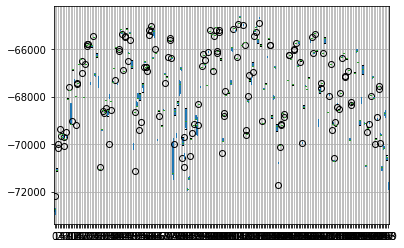

In [9]:
### Boxplot of log-likelihood across all configurations
logLikMtx = logLik_comb_vec.cpu().data.numpy()
logLikMtx_pd = pd.DataFrame(logLikMtx)
logLikMtx_pd.T.boxplot()